In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import yfinance as yf
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

## Factor data

In [2]:
factors = pd.read_csv("./data/factors2.csv", index_col="Date")

# convert Date index to datetime object
factors.index= pd.to_datetime(factors.index, format="%Y%m%d")

# get monthly avg
factors = factors.resample('BM').mean()

factors.head

ParserError: Error tokenizing data. C error: Expected 2 fields in line 5, saw 5


<AxesSubplot:xlabel='Date'>

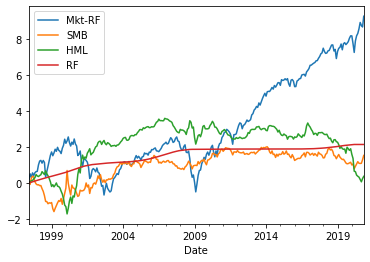

In [4]:
factors_cum = factors.cumsum()
factors_cum.plot.line()

## Asset returns

In [5]:
etsy = yf.Ticker("ETSY")
hist = etsy.history(period="max", auto_adjust=True, rounding=False)
price = hist[["Close"]]
monthly_price = price.resample('BM').last()

# calculate monthly returns
monthly_returns = monthly_price.pct_change().dropna()

# calculate excess monthly returns
excess_returns = (monthly_returns['Close'] - factors['RF']).dropna()
excess_returns = pd.DataFrame(data=excess_returns.values, index=excess_returns.index, columns=["Returns"])

excess_returns.head

<bound method NDFrame.head of              Returns
Date                
2015-05-29 -0.246403
2015-06-30 -0.161695
2015-07-31  0.483274
2015-08-31 -0.312380
2015-09-30 -0.044662
...              ...
2020-07-31  0.114374
2020-08-31  0.011151
2020-09-30  0.016124
2020-10-30 -0.000329
2020-11-30  0.321655

[67 rows x 1 columns]>

<AxesSubplot:xlabel='Date'>

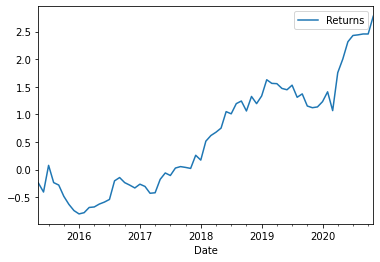

In [6]:
excess_returns_cum = excess_returns.cumsum()
excess_returns_cum.plot.line()

## Regression analysis

In [7]:
# join factors to returns dfs
data = factors.join(excess_returns).dropna()

y = data[["Returns"]] 
x = data[["Mkt-RF","SMB","HML"]]


ols = sm.OLS(y,x)

result = ols.fit()
betas = result.params
print(betas)


Mkt-RF    0.344029
SMB       0.257253
HML      -0.159444
dtype: float64


## Required rate of return

In [10]:
latest_factors = factors.tail(1).to_dict('r')[0]

RRR = latest_factors["RF"]
    + betas["Mkt-RF"] * latest_factors["Mkt-RF"]
    + betas["SMB"] * latest_factors["SMB"]
    + betas["HML"] * latest_factors["HML"]

print(f"Required rate of return is: {RRR}")

Required rate of return is: 0.2462936811626845
